# RestNet

this file will use folder "dataset_used" that generate from "BreakHisModel-1.ipynb"
and this will be used transfer learning / pre trained model RestNet

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.applications import ResNet50V2
from keras.layers import Input, Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping

In [2]:
# Checking their lengths
# train 
len_train_benign = len(os.listdir("../dataset_used/Cancer_train/benign/"))
len_train_malignant = len(os.listdir("../dataset_used/Cancer_train/malignant/"))
# test 
len_test_benign = len(os.listdir("../dataset_used/Cancer_test/benign/"))
len_test_malignant = len(os.listdir("../dataset_used/Cancer_test/malignant/"))
# val 
len_validation_benign = len(os.listdir("../dataset_used/Cancer_validation/benign/"))
len_validation_malignant = len(os.listdir("../dataset_used/Cancer_validation/malignant/"))

print("Training Data:")
print(" ")
print("Benign   :", len_train_benign)
print("Malignant:", len_train_malignant)
print(" ")
print("Validation Data")
print(" ")
print("Benign size    :",len_validation_benign)
print("Malignant size :",len_validation_malignant)
print(" ")
print("Testing Data:")
print(" ")
print("Benign size    :",len_test_benign)
print("Malignant size :",len_test_malignant)

Training Data:
 
Benign   : 4378
Malignant: 4378
 
Validation Data
 
Benign size    : 93
Malignant size : 244
 
Testing Data:
 
Benign size    : 380
Malignant size : 807


# Image Data Generator
- Reference: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- Generates batches of tensor image data with real-time data augmentation.
- Thus CNN sees new set of images with different variation at each epoch.
- One of the useful methods to prevent the model from Overfitting.

In [3]:
# Defining Image Data Generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    )

In [4]:
# Setting up the images for image data generator
train_generator = datagen.flow_from_directory(
  "../dataset_used/Cancer_train/",
  target_size=(128, 128),
  class_mode="categorical",
  batch_size = 32, 
  )
val_generator = datagen.flow_from_directory(
  "../dataset_used/Cancer_validation/", 
  target_size=(128, 128), 
  class_mode="categorical",
  batch_size=32, 
  )

Found 8756 images belonging to 2 classes.
Found 337 images belonging to 2 classes.


# model CNN 
- with RestNet

In [5]:
#Defining the base model -> Fine Tune
ResNet50V2_layer = ResNet50V2(
  include_top=False,
  input_shape=(128, 128, 3)
)

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(ResNet50V2_layer.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in ResNet50V2_layer.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


In [6]:
cancer_model = Sequential([
  # RestNet Layer
  ResNet50V2_layer,
  
  # Flattening the layers
  Flatten(),

  # Adding the dense layer
  Dense(256, activation='relu'),
  # Dropout...
  Dense(128, activation='relu'),
  Dense(2, activation='softmax'),
])

# cancer_model.layers[0].trainable = False
cancer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 31,986,818
Trainable params: 31,403,138
Non-trainable params: 583,680
_________________________________________________________________


In [7]:
ResNet50V2_layer.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 66, 66, 64)   0           ['conv1_conv[0][0]']    

# HyperParameter Tuning

In [8]:
# Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate=0.001,
  decay_steps=1000.0,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [9]:
# Compiling the model
cancer_model.compile(
  loss='categorical_crossentropy', 
  optimizer = get_optimizer(), 
  metrics = ['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [10]:
# Model is fitted using train and validation generator for 200 epochs
import time

start_time = time.time()

history = cancer_model.fit(
  train_generator, 
  validation_data=val_generator, 
  epochs=200 ,
  callbacks=[early_stop], 
  verbose = 1
  )

Epoch 1/200
274/274 [==============================] - 232s 791ms/step - loss: 0.4610 - accuracy: 0.8086 - val_loss: 0.3852 - val_accuracy: 0.8516
Epoch 2/200
274/274 [==============================] - 212s 772ms/step - loss: 0.3106 - accuracy: 0.8786 - val_loss: 2.4728 - val_accuracy: 0.8427
Epoch 3/200
274/274 [==============================] - 210s 764ms/step - loss: 0.2865 - accuracy: 0.8908 - val_loss: 0.2345 - val_accuracy: 0.9318
Epoch 4/200
274/274 [==============================] - 210s 763ms/step - loss: 0.2189 - accuracy: 0.9119 - val_loss: 0.2761 - val_accuracy: 0.8754
Epoch 5/200
274/274 [==============================] - 220s 799ms/step - loss: 0.1676 - accuracy: 0.9362 - val_loss: 0.2164 - val_accuracy: 0.9169
Epoch 6/200
274/274 [==============================] - 219s 796ms/step - loss: 0.1456 - accuracy: 0.9431 - val_loss: 0.1845 - val_accuracy: 0.9228
Epoch 7/200
274/274 [==============================] - 217s 788ms/step - loss: 0.1359 - accuracy: 0.9494 - val_loss: 0

In [12]:
end_time = time.time()
print("The time of execution of above program is :",(end_time-start_time) * 10**3, "ms")

The time of execution of above program is : 23778339.067220688 ms


Total time: 93m 1.1s

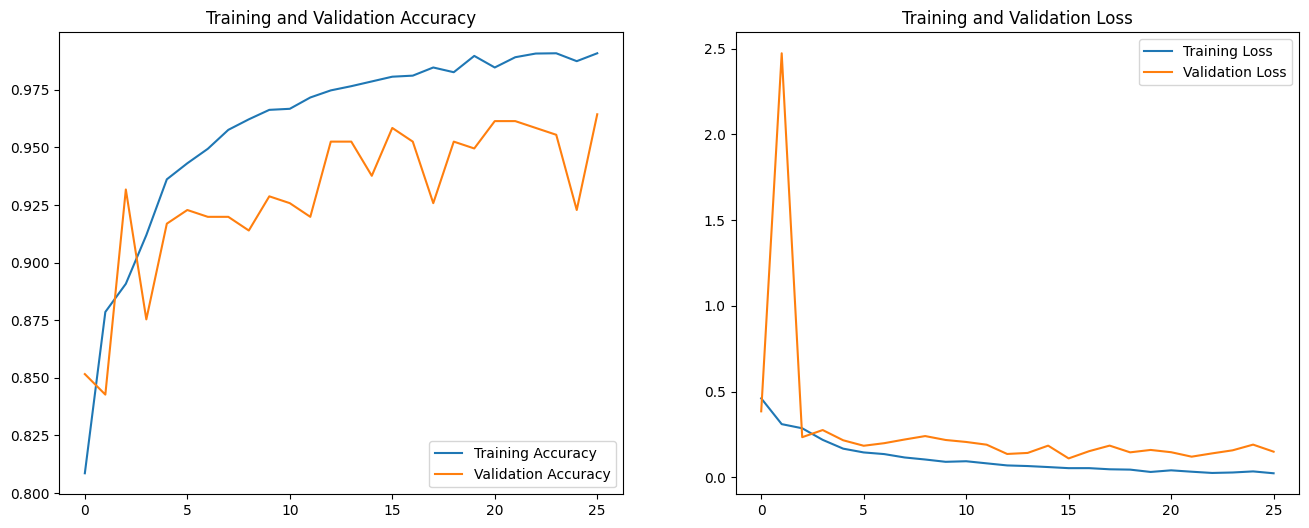

In [13]:
# Plotting the model results

# Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

# No of epochs it trained
epochs_range = history.epoch

# Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
# Loading the test data using Image Data Generator
test_gen = datagen.flow_from_directory(
  "../dataset_used/Cancer_test/", 
  target_size=(128,128), 
  class_mode="categorical", 
  batch_size=1, 
  shuffle=False
  )

Found 1187 images belonging to 2 classes.


In [15]:
pred = cancer_model.evaluate(test_gen)

1187/1187 [==============================] - 60s 50ms/step - loss: 0.1504 - accuracy: 0.9638


In [ ]:
# os.mkdir("../src/output/restnet")

In [ ]:
cancer_model.save(filepath="../src/output/restnet/restnet50v2_model_fineTune.h5")